In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from eofs.xarray import Eof
from cartopy import crs as ccrs, feature as cfeature
import glob, os
import s3fs
import fsspec

In [2]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

In [3]:
def add_cyclic_point(xarray_obj, dim='lon', period=360):
    if period is None:
        period = xarray_obj.sizes[dim] / xarray_obj.coords[dim][:2].diff(dim).item()
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
    return xr.concat([xarray_obj, first_point], dim=dim)

In [4]:
landmask = cfeature.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')

In [5]:
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/OHUTCR-data'
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))
pattern = f's3://{path}/*.nc'
files = sorted(fs.glob(pattern))
fileset = [fs.open(file) for file in files]
fileset

[<File-like object S3FileSystem, pythia/OHUTCR-data/CESM1-CAM5_CO2.cam.h0.mean.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/CESM1-CAM5_ctrl.cam.h0.mean.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/OHUTCR-feedbacks.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/cmip5em-tcr-mean-output.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/cold4-model-tcr-mean-output.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/pop_frc.b.e11.B1850C5CN.f19_g16.130429.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/warm13-model-tcr-mean-output.nc>]

In [6]:
ctrl_qf = xr.open_dataset(fileset[5])
models_warm = ['BNU-ESM', 'MIROC-ESM', 'NorESM1-ME', 
               'inmcm4', 'MRI-CGCM3', 'CESM1-BGC', 'NorESM1-M', 'bcc-csm1-1-m', 
               'CNRM-CM5-2', 'CCSM4', 'bcc-csm1-1', 'CSIRO-Mk3-6-0']
models_cold = ['CNRM-CM5', 'MIROC5', 'ACCESS1-3']

filenames = []
for model in models_warm:
    filenames.append('hfds_Omon_'+model+'_anom_r1i1p1_1x1_monthly_mean.nc')

filepath = './hfds_TCR_diff_1x1/'
temp_hfds_dataset = [xr.open_dataset(filepath + filename, decode_times=False).mean(dim='time') for filename in filenames]
hfds_dataset = xr.concat(temp_hfds_dataset, 'model')

cfilenames = []
for model in models_cold:
    cfilenames.append('hfds_Omon_'+model+'_anom_r1i1p1_1x1_monthly_mean.nc')

ctemp_hfds_dataset = [xr.open_dataset(filepath + filename, decode_times=False).mean(dim='time') for filename in cfilenames]
chfds_dataset = xr.concat(ctemp_hfds_dataset, 'model')

In [7]:
resp = xr.open_dataset(fileset[6]).drop_sel(model='GFDL-ESM2G')
cold_resp = xr.open_dataset(fileset[4]).drop_sel(model='ACCESS1-0')
ctrl = xr.open_dataset(fileset[1]).isel(time=0).drop('time')
co2 = xr.open_dataset(fileset[0]).isel(time=0).drop('time')
em = xr.open_dataset(fileset[3])

In [8]:
tcr_tas = add_cyclic_point(resp.TREFHT - ctrl.TREFHT)
tcr_sic = add_cyclic_point(resp.ICEFRAC - ctrl.ICEFRAC)*100
tcr_lcc = add_cyclic_point(resp.CLDLOW - ctrl.CLDLOW)*100

cold_tas = add_cyclic_point(cold_resp.TREFHT - ctrl.TREFHT)
cold_sic = add_cyclic_point(cold_resp.ICEFRAC - ctrl.ICEFRAC)*100
cold_lcc = add_cyclic_point(cold_resp.CLDLOW - ctrl.CLDLOW)*100

em_tas = add_cyclic_point(em.TREFHT - ctrl.TREFHT)
em_sic = add_cyclic_point(em.ICEFRAC - ctrl.ICEFRAC)*100
em_lcc = add_cyclic_point(em.CLDLOW - ctrl.CLDLOW)*100

co2_tas = add_cyclic_point(co2.TREFHT - ctrl.TREFHT)
co2_sic = add_cyclic_point(co2.ICEFRAC - ctrl.ICEFRAC)*100
co2_lcc = add_cyclic_point(co2.CLDLOW - ctrl.CLDLOW)*100

In [9]:
hfds_dataset

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, model: 12)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: model
Data variables:
    hfds     (model, lat, lon) float32 nan nan nan ... 0.0978 0.09273 0.09273

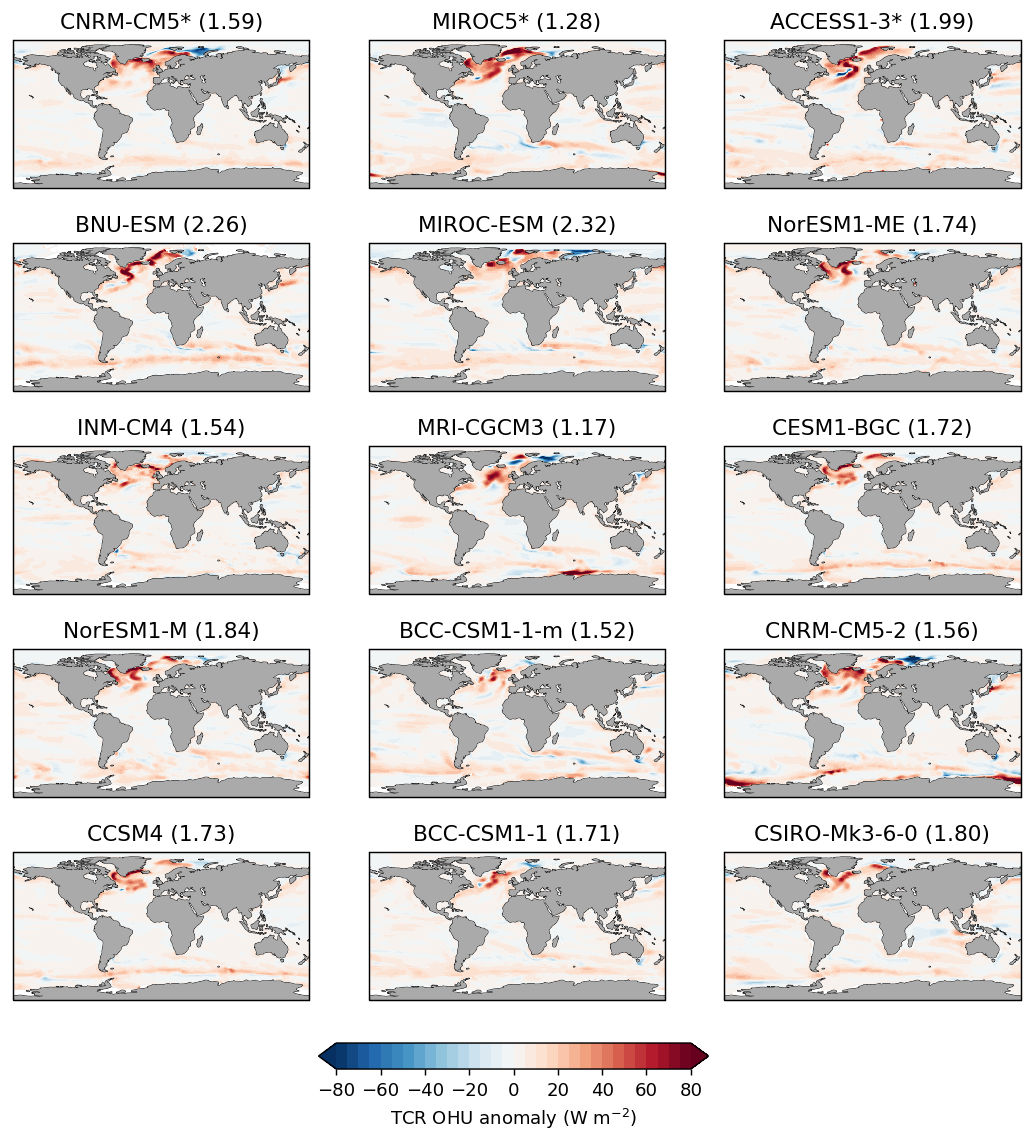

In [10]:
levs = np.arange(-80, 81, 5)

fig = plt.figure(1, figsize=(10, 10), dpi=130)

for j, m in enumerate(chfds_dataset.model):
    ax = fig.add_subplot(5, 3, j+1, projection=ccrs.PlateCarree())
    plot = ax.contourf(chfds_dataset.lon, chfds_dataset.lat, chfds_dataset.hfds.sel(model=m), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
    ax.coastlines(linewidths=0.5)
    ax.add_feature(landmask)
    ax.set_title(models_cold[j]+'* (%.2f)' %global_average(chfds_dataset.hfds.sel(model=m)).values)
    
for j, m in enumerate(hfds_dataset.model):
    ax = fig.add_subplot(5, 3, j+4, projection=ccrs.PlateCarree())
    plot = ax.contourf(hfds_dataset.lon, hfds_dataset.lat, hfds_dataset.hfds.sel(model=m), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
    ax.coastlines(linewidths=0.5)
    ax.add_feature(landmask)
    model = models_warm[j]
    if model == 'inmcm4':
        ax.set_title('INM-CM4 (%.2f)' %global_average(hfds_dataset.hfds.sel(model=m)).values)
    elif model == 'bcc-csm1-1':
        ax.set_title('BCC-CSM1-1 (%.2f)' %global_average(hfds_dataset.hfds.sel(model=m)).values)
    elif model == 'bcc-csm1-1-m':
        ax.set_title('BCC-CSM1-1-m (%.2f)' %global_average(hfds_dataset.hfds.sel(model=m)).values)
    else:
        ax.set_title(model+' (%.2f)' %global_average(hfds_dataset.hfds.sel(model=m)).values)

# ax_m = fig.add_subplot(6, 3, 16, projection=ccrs.PlateCarree())
# plot_m = ax_m.contourf(tcr_tas.lon, tcr_tas.lat, tcr_tas.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
# plot_m_zero = ax_m.contour(tcr_tas.lon, tcr_tas.lat, tcr_tas.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
# ax_m.coastlines(linewidths=0.5)
# ax_m.set_title('Ensemble mean')

# ax_e = fig.add_subplot(6, 3, 17, projection=ccrs.PlateCarree())
# plot_e = ax_e.contourf(em_tas.lon, em_tas.lat, em_tas, cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
# plot_e_zero = ax_e.contour(em_tas.lon, em_tas.lat, em_tas, colors='k', levels=[0.0], linestyles='--', linewidths=1)
# ax_e.coastlines(linewidths=0.5)
# ax_e.set_title('CM Q-flux')

# ax_c = fig.add_subplot(6, 3, 18, projection=ccrs.PlateCarree())
# plot_c = ax_c.contourf(co2_tas.lon, co2_tas.lat, co2_tas, cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
# plot_c_zero = ax_c.contour(co2_tas.lon, co2_tas.lat, co2_tas, colors='k', levels=[0.0], linestyles='--', linewidths=1)
# ax_c.coastlines(linewidths=0.5)
# ax_c.set_title('2xCO2 only')

cax = fig.add_axes([0.36, 0.08, 0.3, 0.02])
fig.colorbar(plot, cax=cax, orientation='horizontal', label='TCR OHU anomaly (W m$^{-2}$)')

/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


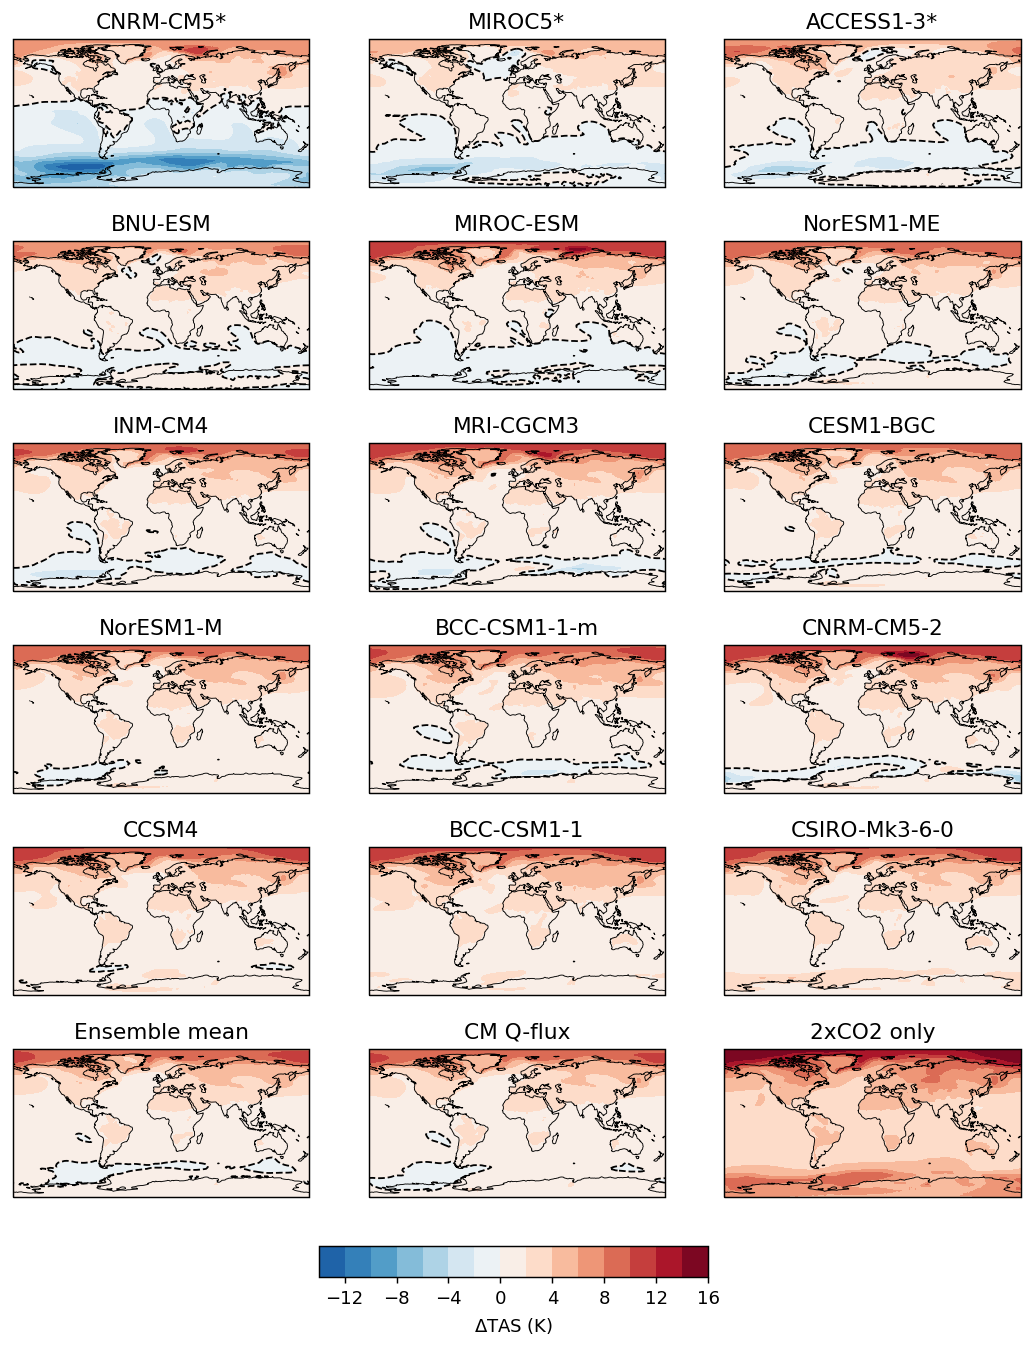

In [11]:
levs = np.arange(-14, 18, 2)

fig = plt.figure(1, figsize=(10, 12), dpi=130)

for j, m in enumerate(cold_resp.model):
    ax = fig.add_subplot(6, 3, j+1, projection=ccrs.PlateCarree())
    plot = ax.contourf(cold_tas.lon, cold_tas.lat, cold_tas.sel(model=m), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
    plot_zero = ax.contour(cold_tas.lon, cold_tas.lat, cold_tas.sel(model=m), colors='k', levels=[0.0], linestyles='--', linewidths=1)
    ax.coastlines(linewidths=0.5)
    ax.set_title(str(m.values)+'*')
    
for j, m in enumerate(resp.model):
    ax = fig.add_subplot(6, 3, j+4, projection=ccrs.PlateCarree())
    plot = ax.contourf(tcr_tas.lon, tcr_tas.lat, tcr_tas.sel(model=m), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
    plot_zero = ax.contour(tcr_tas.lon, tcr_tas.lat, tcr_tas.sel(model=m), colors='k', levels=[0.0], linestyles='--', linewidths=1)
    ax.coastlines(linewidths=0.5)
    if m == 'inmcm4':
        ax.set_title('INM-CM4')
    elif m == 'bcc-csm1-1':
        ax.set_title('BCC-CSM1-1')
    elif m == 'bcc-csm1-1-m':
        ax.set_title('BCC-CSM1-1-m')
    else:
        ax.set_title(str(m.values))

ax_m = fig.add_subplot(6, 3, 16, projection=ccrs.PlateCarree())
plot_m = ax_m.contourf(tcr_tas.lon, tcr_tas.lat, tcr_tas.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
plot_m_zero = ax_m.contour(tcr_tas.lon, tcr_tas.lat, tcr_tas.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
ax_m.coastlines(linewidths=0.5)
ax_m.set_title('Ensemble mean')

ax_e = fig.add_subplot(6, 3, 17, projection=ccrs.PlateCarree())
plot_e = ax_e.contourf(em_tas.lon, em_tas.lat, em_tas, cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
plot_e_zero = ax_e.contour(em_tas.lon, em_tas.lat, em_tas, colors='k', levels=[0.0], linestyles='--', linewidths=1)
ax_e.coastlines(linewidths=0.5)
ax_e.set_title('CM Q-flux')

ax_c = fig.add_subplot(6, 3, 18, projection=ccrs.PlateCarree())
plot_c = ax_c.contourf(co2_tas.lon, co2_tas.lat, co2_tas, cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs)
plot_c_zero = ax_c.contour(co2_tas.lon, co2_tas.lat, co2_tas, colors='k', levels=[0.0], linestyles='--', linewidths=1)
ax_c.coastlines(linewidths=0.5)
ax_c.set_title('2xCO2 only')

cax = fig.add_axes([0.36, 0.08, 0.3, 0.02])
fig.colorbar(plot, cax=cax, orientation='horizontal', label='$\Delta$TAS (K)')

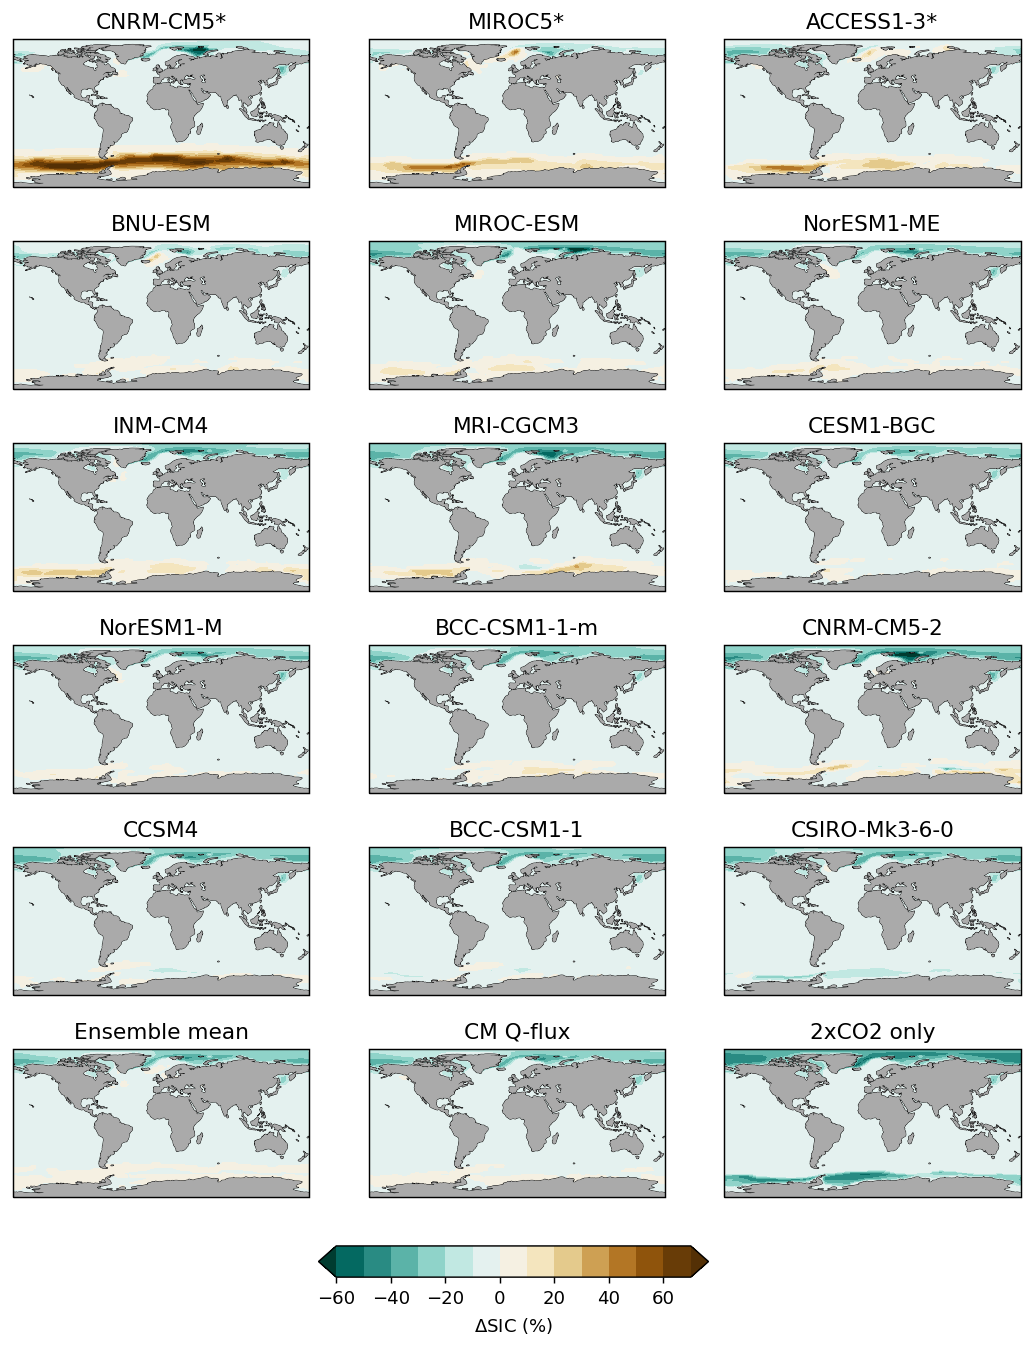

In [12]:
levs = np.arange(-60, 80, 10)

fig = plt.figure(1, figsize=(10, 12), dpi=130)

for j, m in enumerate(cold_resp.model):
    ax = fig.add_subplot(6, 3, j+1, projection=ccrs.PlateCarree())
    plot = ax.contourf(cold_sic.lon, cold_sic.lat, cold_sic.sel(model=m), cmap='BrBG_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
    ax.coastlines(linewidths=0.5)
    ax.add_feature(landmask)
    ax.set_title(str(m.values)+'*')
    
for j, m in enumerate(resp.model):
    ax = fig.add_subplot(6, 3, j+4, projection=ccrs.PlateCarree())
    plot = ax.contourf(tcr_sic.lon, tcr_sic.lat, tcr_sic.sel(model=m), cmap='BrBG_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
    ax.coastlines(linewidths=0.5)
    ax.add_feature(landmask)
    if m == 'inmcm4':
        ax.set_title('INM-CM4')
    elif m == 'bcc-csm1-1':
        ax.set_title('BCC-CSM1-1')
    elif m == 'bcc-csm1-1-m':
        ax.set_title('BCC-CSM1-1-m')
    else:
        ax.set_title(str(m.values))

ax_m = fig.add_subplot(6, 3, 16, projection=ccrs.PlateCarree())
plot_m = ax_m.contourf(tcr_sic.lon, tcr_sic.lat, tcr_sic.mean(dim='model'), cmap='BrBG_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
ax_m.coastlines(linewidths=0.5)
ax_m.add_feature(landmask)
ax_m.set_title('Ensemble mean')

ax_e = fig.add_subplot(6, 3, 17, projection=ccrs.PlateCarree())
plot_e = ax_e.contourf(em_sic.lon, em_sic.lat, em_sic, cmap='BrBG_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
ax_e.coastlines(linewidths=0.5)
ax_e.add_feature(landmask)
ax_e.set_title('CM Q-flux')

ax_c = fig.add_subplot(6, 3, 18, projection=ccrs.PlateCarree())
plot_c = ax_c.contourf(co2_sic.lon, co2_sic.lat, co2_sic, cmap='BrBG_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
ax_c.coastlines(linewidths=0.5)
ax_c.add_feature(landmask)
ax_c.set_title('2xCO2 only')

cax = fig.add_axes([0.36, 0.08, 0.3, 0.02])
fig.colorbar(plot, cax=cax, orientation='horizontal', label='$\Delta$SIC (%)')

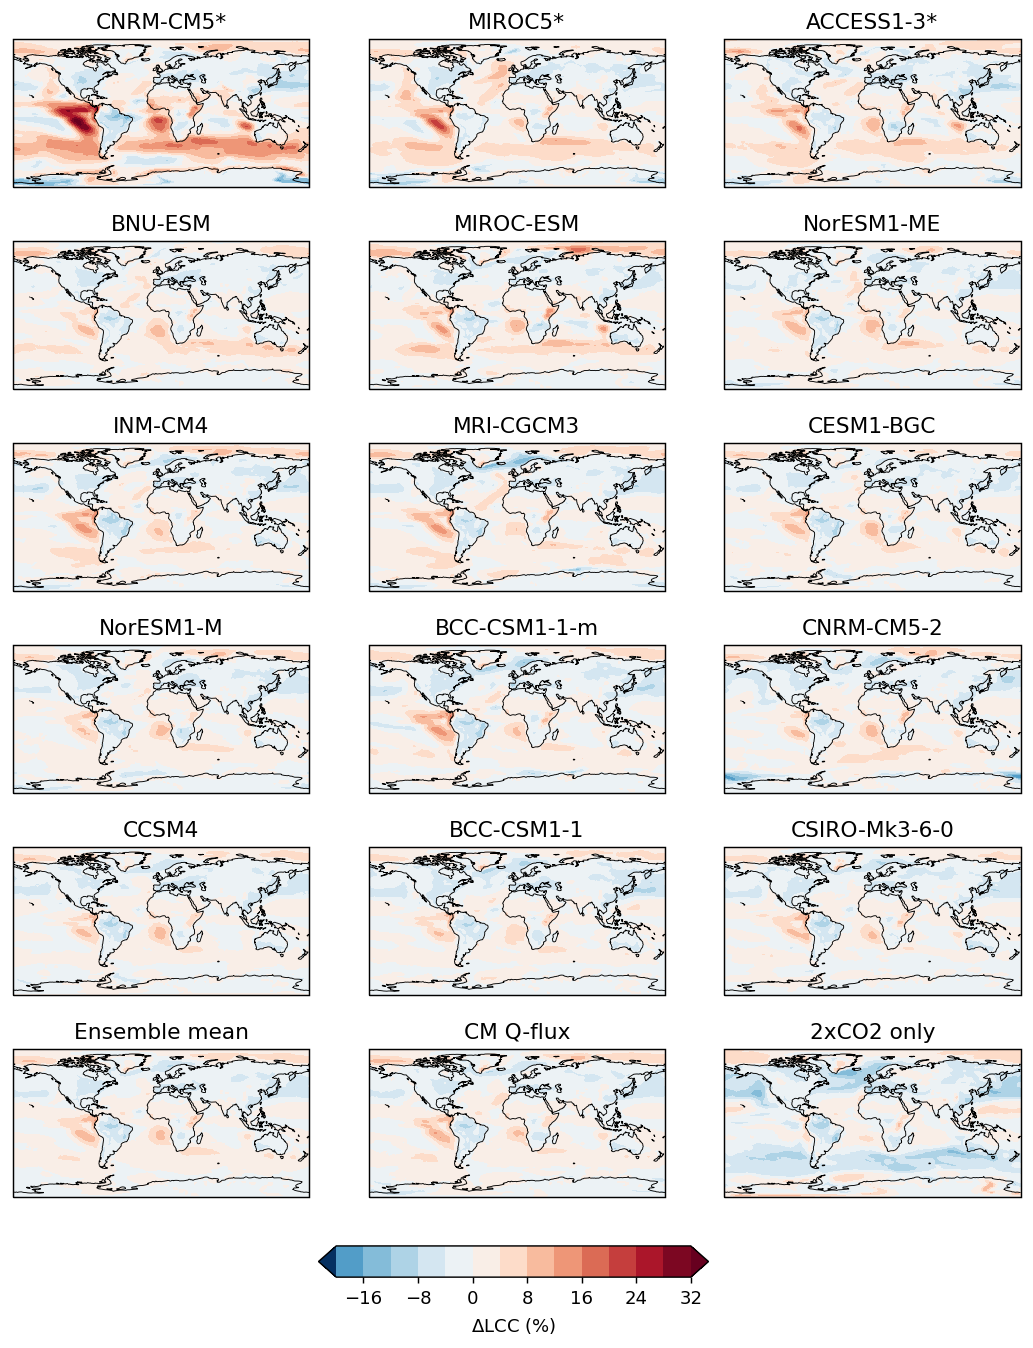

In [13]:
levs = np.arange(-20, 34, 4)

fig = plt.figure(1, figsize=(10, 12), dpi=130)

for j, m in enumerate(cold_resp.model):
    ax = fig.add_subplot(6, 3, j+1, projection=ccrs.PlateCarree())
    plot = ax.contourf(cold_lcc.lon, cold_lcc.lat, cold_lcc.sel(model=m), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
    ax.coastlines(linewidths=0.5)
    ax.set_title(str(m.values)+'*')
    
for j, m in enumerate(resp.model):
    ax = fig.add_subplot(6, 3, j+4, projection=ccrs.PlateCarree())
    plot = ax.contourf(tcr_lcc.lon, tcr_lcc.lat, tcr_lcc.sel(model=m), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
    ax.coastlines(linewidths=0.5)
    if m == 'inmcm4':
        ax.set_title('INM-CM4')
    elif m == 'bcc-csm1-1':
        ax.set_title('BCC-CSM1-1')
    elif m == 'bcc-csm1-1-m':
        ax.set_title('BCC-CSM1-1-m')
    else:
        ax.set_title(str(m.values))

ax_m = fig.add_subplot(6, 3, 16, projection=ccrs.PlateCarree())
plot_m = ax_m.contourf(tcr_lcc.lon, tcr_lcc.lat, tcr_lcc.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
ax_m.coastlines(linewidths=0.5)
ax_m.set_title('Ensemble mean')

ax_e = fig.add_subplot(6, 3, 17, projection=ccrs.PlateCarree())
plot_e = ax_e.contourf(em_lcc.lon, em_lcc.lat, em_lcc, cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
ax_e.coastlines(linewidths=0.5)
ax_e.set_title('CM Q-flux')

ax_c = fig.add_subplot(6, 3, 18, projection=ccrs.PlateCarree())
plot_c = ax_c.contourf(co2_lcc.lon, co2_lcc.lat, co2_lcc, cmap='RdBu_r', norm=colors.CenteredNorm(), levels=levs, extend='both')
ax_c.coastlines(linewidths=0.5)
ax_c.set_title('2xCO2 only')

cax = fig.add_axes([0.36, 0.08, 0.3, 0.02])
fig.colorbar(plot, cax=cax, orientation='horizontal', label='$\Delta$LCC (%)')